<center><img src="Images/emotion classification.png"/></center>

# Abstract

### Introduction

Text summarization is one of the most useful NLP applications that can help users to extract the main information from large documents. Automatic summarization can be either extractive or abstractive, depending on whether the summary is composed of sentences or phrases from the original text or generated by natural language generation techniques. In this notebook, I will explore the task of emotion classification using a dataset of short texts.

### Challenge
Emotion classification is the task of assigning an emotion label to a text, such as anger, fear, joy, love. This task can be useful for understanding the sentiments and opinions of social media users, as well as for providing personalized recommendations and feedback. However, emotion classification is challenging because emotions are subjective and context-dependent, and textual data can be noisy and informal. In this project, I will use a dataset of short texts labeled with six emotion categories: joy, sadness, anger, fear, love, and surprise. 

The dataset contains the list of documents with emotion flag. Also the dataset is split into train, test & validation for building the machine learning model. Here is the link of this dataset:
<a href="https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/" target="_blank">link</a>

### Approach

For the classification I use:
* **LSTM Model** – using attension mechanism
* **pre-trained RoBERTa model: fine-tuning of a pre-trained RoBERTa model** – the heavy weapon of NLP tasks these days, a transfer learning from a BERT-based model, resulting in the highest accuracy for this task.

1-I will build a deep learning model based on Long Short-Term Memory (LSTM) networks and attention mechanisms to classify the text into their corresponding emotion labels.LSTM networks are a type of recurrent neural networks that can capture long-term dependencies and sequential information in text data. Attention mechanisms are a way of enhancing the representation of the text by focusing on the most relevant parts of the input sequence. By combining LSTM networks and attention mechanisms, I hope to achieve a high accuracy and interpretability for the emotion classification task.



2-Before training by pre-trained RoBERTa model,  I start with custom **Text Pre-processing**: in addition to typical stop-word removal, lemmatization, etc. I also did tweet-specific processing: e.g. removing Twitter handles and URLs, transforming emojis into text . 
 



### Results
**The deep-learned RoBERTa-based classifier produced a weighted accuracy of 96% .**

**The LSTM Model produced a weighted accuracy of 90.8% .**


| <img src="Images/LSTM_Accuracy_Loss.png" width="800"> | <img src="Images/confusion_Matrix_LSTM.png" width="500"> |
|:---:|:---:|
|Accuracy/Loss of LSTM Model|Confusion Matrix of LSTM Model|


| <img src="Images/Roberts_Accuracy_Loss.png" width="800"> | <img src="Images/Roberts_Confusion Matrix.png" width="400"> |
|:---:|:---:|
| Accuracy/Loss of Roberta Model|Confusion Matrix of Roberta Model |

### Importing libraries

In [8]:
!pip install contractions
!pip install nltk
!pip install transformers;

In [2]:
import random
import re
import string

import contractions

import nltk
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from transformers import TFRobertaModel, RobertaTokenizerFast
from keras.utils.vis_utils import plot_model
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint


from tabulate import tabulate
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Exploratory Data Analysis

In [6]:
train_df = pd.read_csv( 'dataset/train.txt', sep=';', names=['content', 'sentiment'], header=0)
test_df = pd.read_csv( 'dataset/test.txt', sep=';', names=['content', 'sentiment'], header=0)
valid_df = pd.read_csv( 'dataset/val.txt', sep=';', names=['content', 'sentiment'], header=0)
data = pd.concat([train_df, test_df, valid_df], axis=0)
data.head(6)


,content,sentiment
0,i can go from feeling so hopeless to so damned...,sadness
1,im grabbing a minute to post i feel greedy wrong,anger
2,i am ever feeling nostalgic about the fireplac...,love
3,i am feeling grouchy,anger
4,ive been feeling a little burdened lately wasn...,sadness
5,ive been taking or milligrams or times recomme...,surprise


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19997 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    19997 non-null  object
 1   sentiment  19997 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


#### A number of texts for each emotion class:

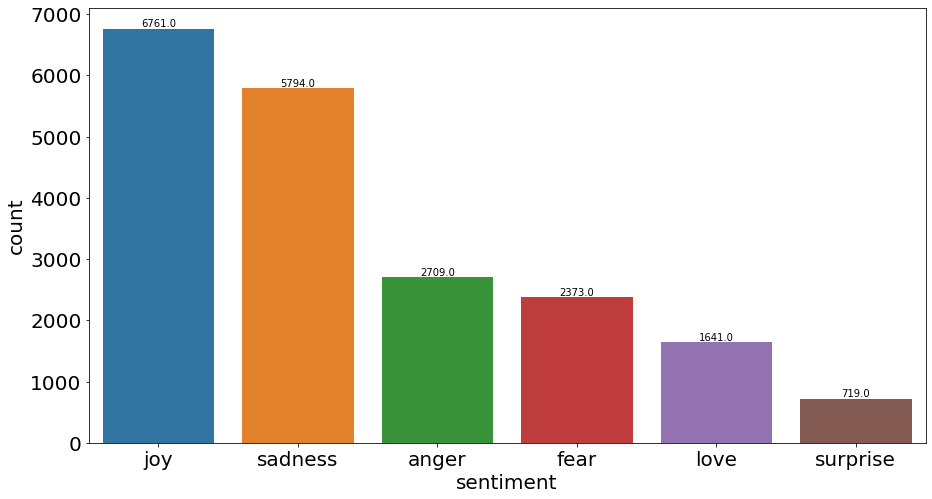

In [14]:
sentiment = data['sentiment'].value_counts()
sentiment_order = list(sentiment.index)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,8))

ax = sns.countplot(x='sentiment', data=data, order=sentiment_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10)
    
plt.show;

#### Mean texts length for each class

In [15]:
df = data.copy()
df['content_len'] = df['content'].apply(len)
df.head()

,content,sentiment,content_len
0,i can go from feeling so hopeless to so damned...,sadness,108
1,im grabbing a minute to post i feel greedy wrong,anger,48
2,i am ever feeling nostalgic about the fireplac...,love,92
3,i am feeling grouchy,anger,20
4,ive been feeling a little burdened lately wasn...,sadness,65


#### Mean number of words per category

In [16]:
df['content_word'] = data['content'].apply(lambda x: len(x.split()))
df.head()

,content,sentiment,content_len,content_word
0,i can go from feeling so hopeless to so damned...,sadness,108,21
1,im grabbing a minute to post i feel greedy wrong,anger,48,10
2,i am ever feeling nostalgic about the fireplac...,love,92,18
3,i am feeling grouchy,anger,20,4
4,ive been feeling a little burdened lately wasn...,sadness,65,12


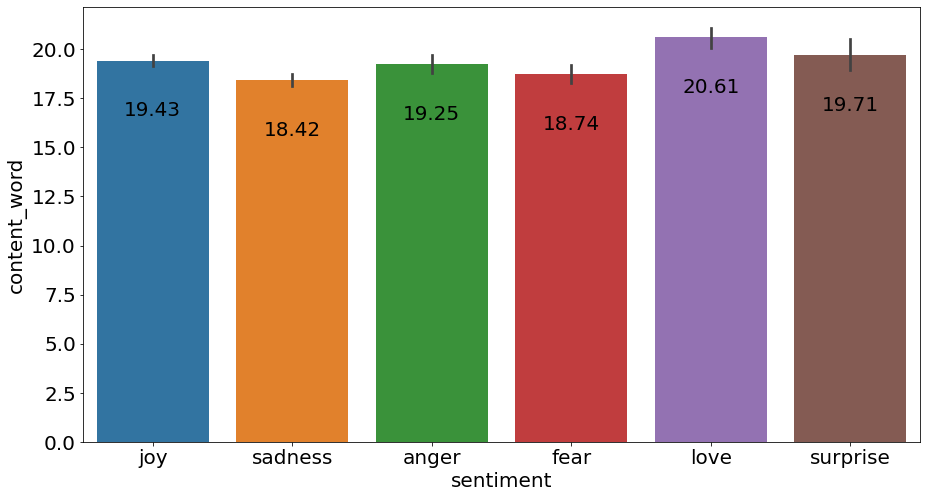

In [33]:

# table
sentiment_grouped_mean_word = df.groupby('sentiment')['content_word'].mean()
sgmword_transpose = sentiment_grouped_mean_word.to_frame().transpose()


# barplot
plt.figure(figsize=(15,8))

ax = sns.barplot(data=df, x='sentiment', y='content_word', estimator=np.mean, order=sentiment_order)
plt.rcParams.update({'font.size': 20})
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, -50), 
                textcoords = 'offset points')
    
plt.show;

## Violinplot
A violin plot is a hybrid of a box plot and a kernel density plot, which shows peaks in the data. It is used to visualize the distribution of numerical data. Unlike a box plot that can only show summary statistics, violin plots depict summary statistics and the density of each variable

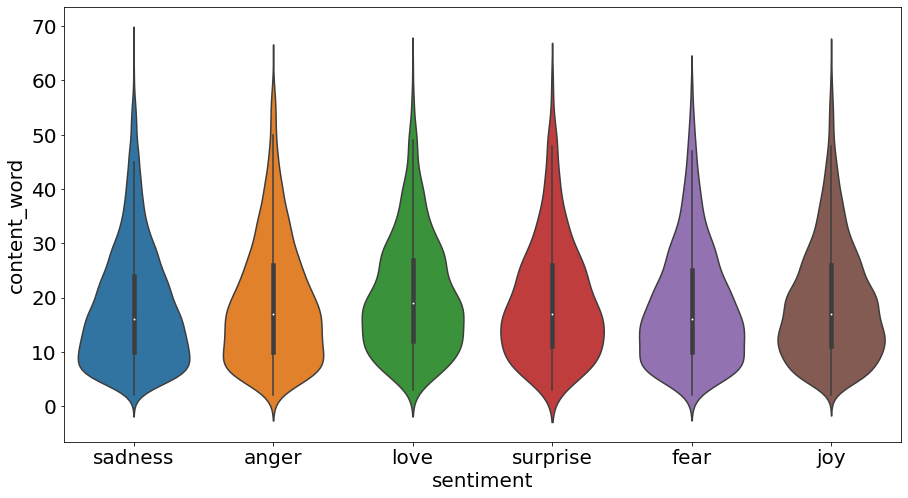

In [17]:
# violinplot
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 20})
sns.violinplot(x='sentiment', y = 'content_word', data=df)
plt.savefig('Images/violinplot.png')
plt.show;

#### Distribution of texts length by emotion class

All distribution are semi-normal. In fact my dataset is blanced.


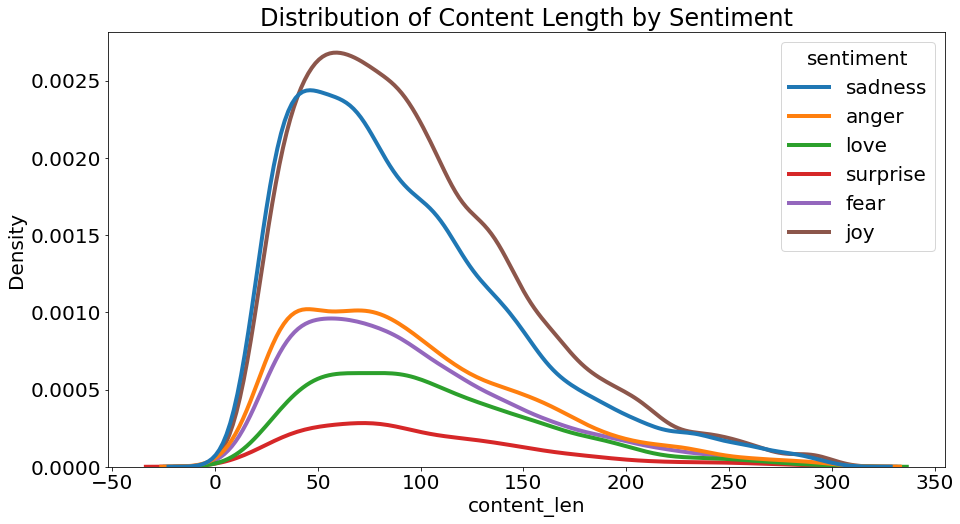

In [31]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 20})
sns.kdeplot(x=df['content_len'], hue=df['sentiment'],  label='content len',linewidth=4, legend=True)
plt.title('Distribution of Content Length by Sentiment')
plt.show;

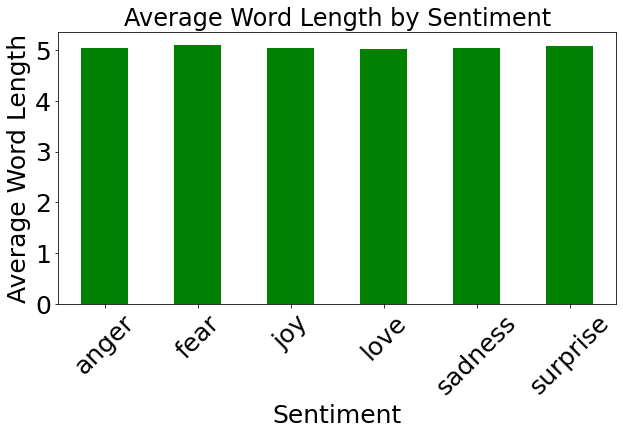

In [30]:
# mean word length for each category.
grouped = df.groupby('sentiment')['content_len', 'content_word'].sum()
grouped['avg_word_len'] = grouped['content_len'] / grouped['content_word']

plt.figure(figsize=(10,5))
ax = grouped['avg_word_len'].plot(kind='bar', color='green')
ax.set_xticklabels(grouped.index, rotation=45)
plt.rcParams.update({'font.size': 20})
plt.title('Average Word Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Length')

plt.show()

### WordCloud

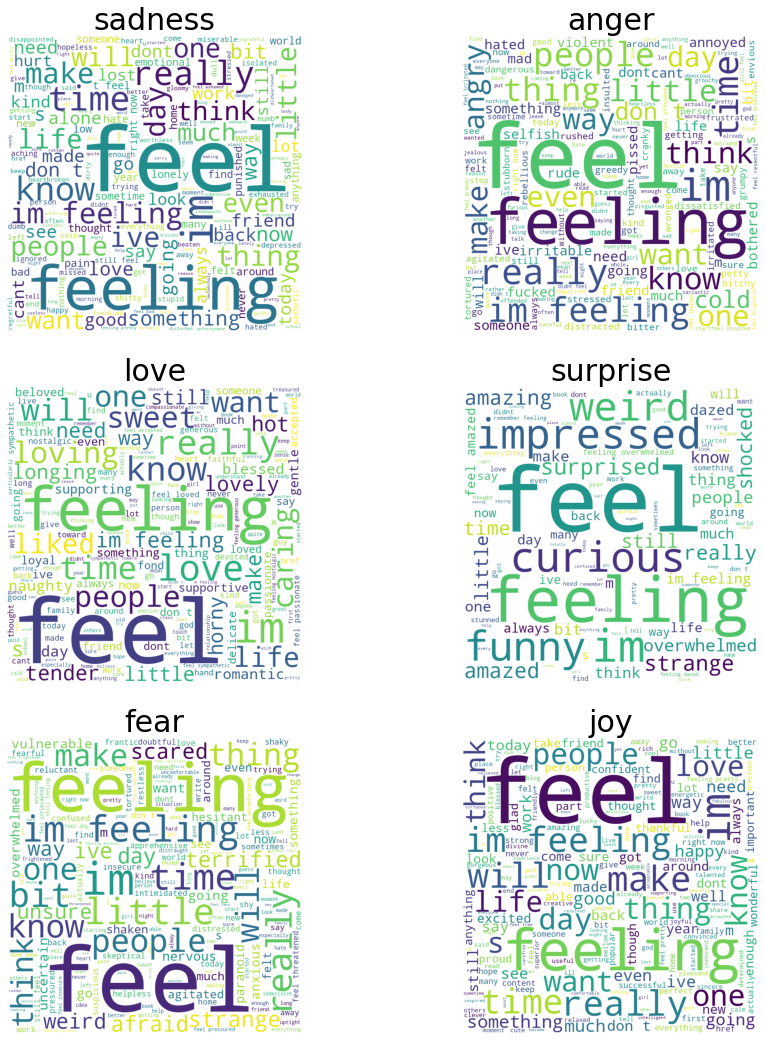

In [28]:
from wordcloud import WordCloud


sentiments = data['sentiment'].unique()
sentiments = list(sentiments)
sentiments = list(sentiments) + list(sentiments[:3])

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
plt.rcParams.update({'font.size': 25})
for ax, sentiment in zip(axes.flatten(), sentiments):
    text = " ".join(data[data['sentiment'] == sentiment]['content'])
    cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
    ax.imshow(cloud)
    ax.set_title(sentiment)
    ax.axis("off")

plt.tight_layout()
plt.show()